In [1]:
import pandas as pd 
import matplotlib

%matplotlib inline


In [2]:
def parser(x):
    return pd.datetime.strptime(x,'%Y-%m-%d')
 
train_df = pd.read_csv('train.csv', header=0,usecols=['date','store','item','sales'])
train_df = train_df[train_df['store']==1]
train_df = train_df[train_df['item']==1]


train_df.head()

df=train_df.copy()


In [3]:
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [4]:
df['date'].min(), df['date'].max()
df['date'] = pd.to_datetime(df['date'])

In [5]:
df.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [6]:
df = df.groupby('date')['sales'].sum().reset_index()
df.head()

,date,sales
0,2013-01-01,13
1,2013-01-02,11
2,2013-01-03,14
3,2013-01-04,13
4,2013-01-05,10


In [7]:
df=df.set_index('date')
y=df

In [8]:
y = df['sales'].resample('MS').mean()

In [9]:
y['2013':].head()

date
2013-01-01    10.580645
2013-02-01    11.500000
2013-03-01    15.387097
2013-04-01    17.400000
2013-05-01    17.129032
Freq: MS, Name: sales, dtype: float64

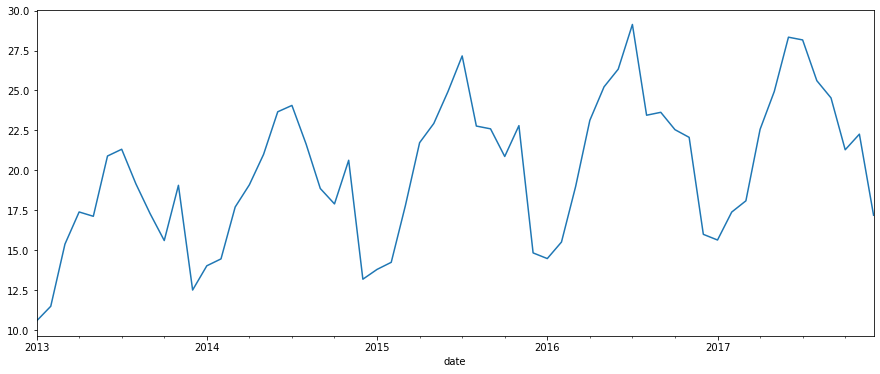

In [10]:
y.plot(figsize=(15, 6))

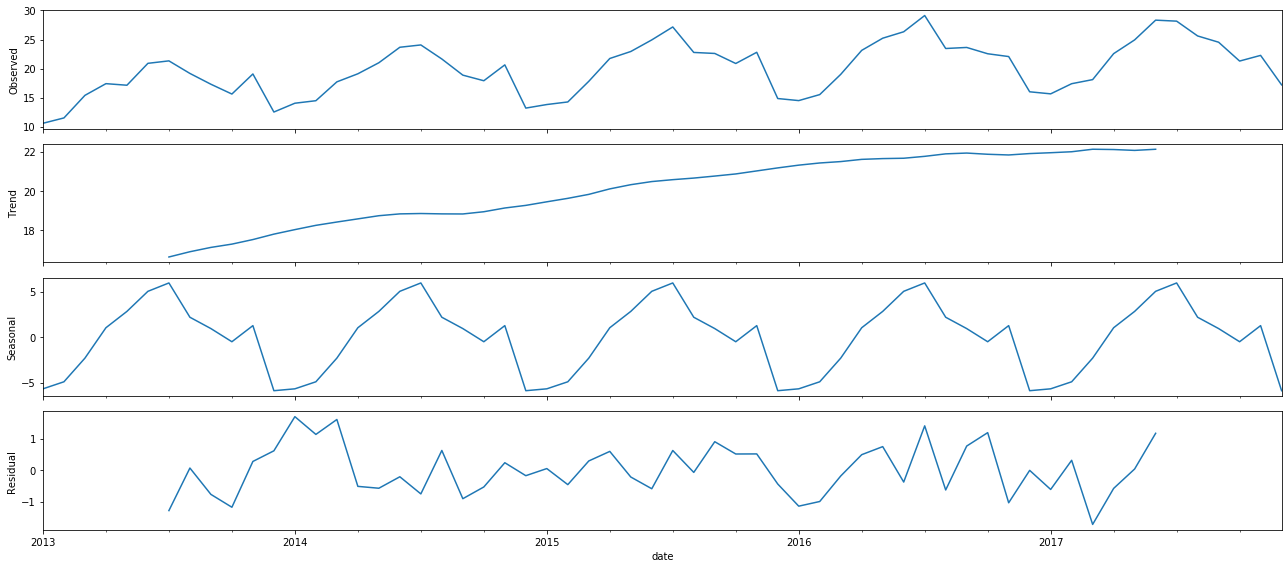

In [11]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()


In [12]:
import itertools
import warnings
warnings.filterwarnings("ignore")
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 365) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 365)
SARIMAX: (0, 0, 1) x (0, 1, 0, 365)
SARIMAX: (0, 1, 0) x (0, 1, 1, 365)
SARIMAX: (0, 1, 0) x (1, 0, 0, 365)


In [ ]:
min=10000000.00
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results=mod.fit()
            if(results.aic<min):
                min=results.aic
                min_param=param
                min_param_seasonal=param_seasonal
            print('ARIMA{}x{}365 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue


ARIMA(0, 0, 0)x(0, 0, 0, 365)365 - AIC:16307.7681346496
ARIMA(0, 0, 0)x(0, 0, 1, 365)365 - AIC:12163.049209073004
ARIMA(0, 0, 1)x(0, 0, 0, 365)365 - AIC:14727.239774771746
ARIMA(0, 0, 1)x(0, 0, 1, 365)365 - AIC:11419.606446148324


In [ ]:
print('ARIMA{}x{}12 - AIC:{}'.format(min_param, min_param_seasonal, min))

In [13]:
from pylab import rcParams
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(y,order=(7,1,7),seasonal_order=(1,0,5,1),
                                       enforce_stationarity=False, enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0278      3.117      0.009      0.993      -6.082       6.138
ar.L2         -0.0116      0.461     -0.025      0.980      -0.916       0.893
ar.L3          0.0350      0.243      0.144      0.885      -0.441       0.511
ar.L4          0.0101      0.242      0.042      0.967      -0.465       0.485
ar.L5         -0.1438      0.218     -0.660      0.509      -0.571       0.284
ar.L6         -0.7647      0.516     -1.482      0.138      -1.776       0.247
ar.L7         -0.1335      2.518     -0.053      0.958      -5.069       4.802
ma.L1         -0.4065     55.575     -0.007      0.994    -109.331     108.518
ma.L2         -0.3239     21.386     -0.015      0.988     -42.240      41.592
ma.L3          0.1735     11.345      0.015      0.988     -22.061      22.408
ma.L4         -0.5244     10.325     -0.051      0.9

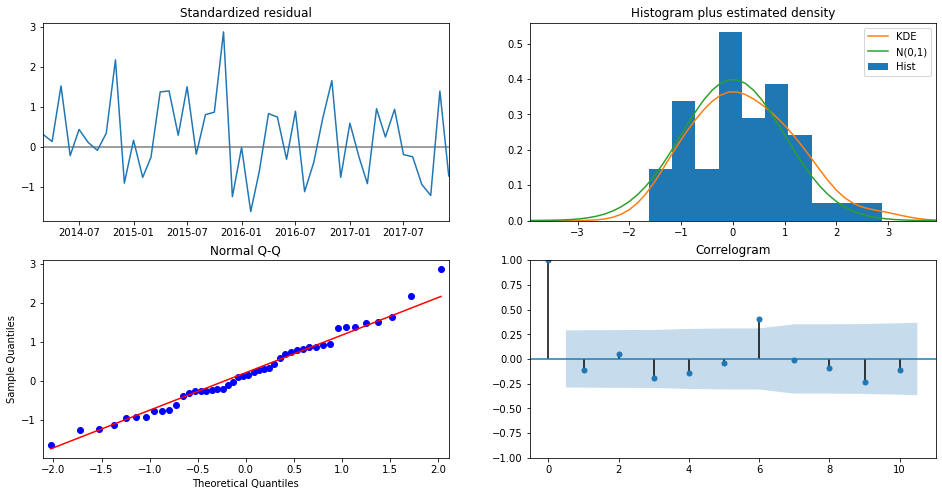

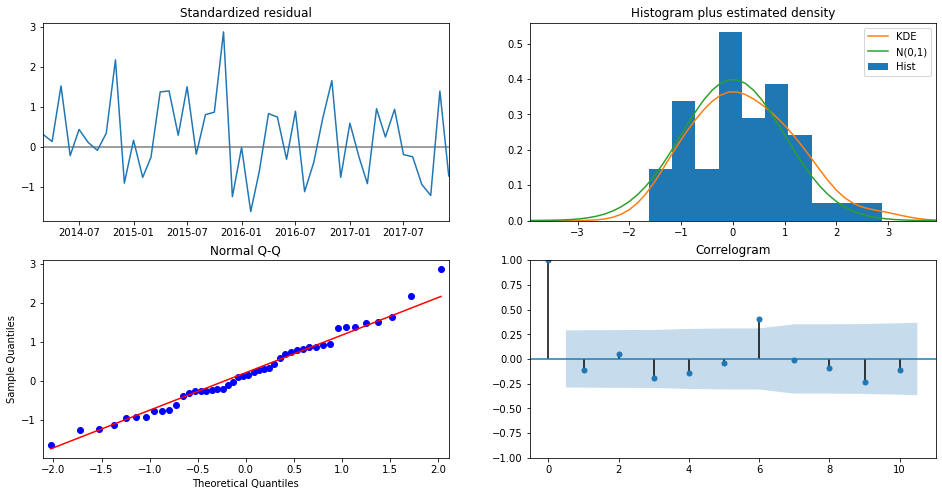

In [14]:
results.plot_diagnostics(figsize=(16, 8))

Text(0, 0.5, 'Sales')

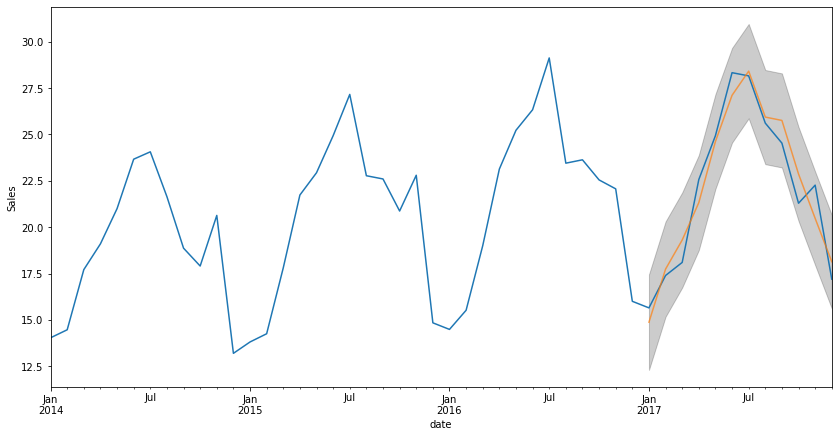

In [15]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('date')
ax.set_ylabel('Sales')


In [16]:
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.metrics import mean_squared_error
expected =  y['2017-01-01':]
predictions = pred.predicted_mean

mae = mean_absolute_error(expected, predictions)
print('MAE: %f' % mae)
mse = mean_squared_error(expected, predictions)
print('MSE: %f' % mse)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

MAE: 0.935341
MSE: 1.131099
RMSE: 1.063532


In [17]:
pred_uc = results.get_forecast(steps=30)
pred_ci = pred_uc.conf_int()

pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
#ax.fill_between(pred_ci.index,
#                pred_ci.iloc[:, 0],
#                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')

Text(17.200000000000003, 0.5, 'Sales')

In [95]:
pred_uc.predicted

AttributeError: 'PredictionResults' object has no attribute 'predicted'

In [85]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()